#### Raphael Mbelli
#### BENCHMARKING NEURAL NETWORK

###### OVERVIEW
Fitting a neural network to the MNIST data, testing alternative network structures, activation functions, optimization methods, and/or hyper-parameter settings while assessing the classification performance accuracy and processing time of each model topology.

In [247]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [248]:
# Common imports: Numpy, os and time.
import numpy as np
import os
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Table creation for Tensor Flow Neural Network Benchmark Experiment Results
import sys
!{sys.executable} -m pip install tabulate
from tabulate import tabulate

# Tensor Flow Neural Network
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed) 

In [249]:
# Load MNIST Data Set
# segmenting data into train, validation & testing sets

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [250]:
#Check the shape of MNIST data aset
# Printout of the shapes of the train, validate and test datasets created above

print("Shape of Training data:   ", X_train.shape)
print("Shape of Validate data:   ", X_valid.shape)
print("Shape of Test data:       ", X_test.shape)

print("\nShape of Training data:   ", y_train.shape)
print("Shape of Validate data:   ", y_valid.shape)
print("Shape of Test data:       ", y_test.shape)

Shape of Training data:    (55000, 784)
Shape of Validate data:    (5000, 784)
Shape of Test data:        (10000, 784)

Shape of Training data:    (55000,)
Shape of Validate data:    (5000,)
Shape of Test data:        (10000,)


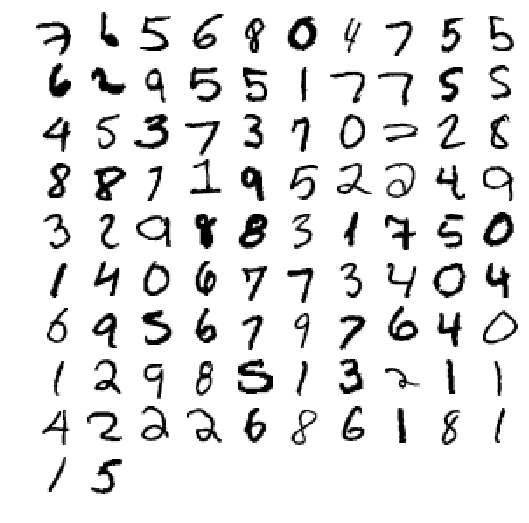

In [251]:
# additonal plots that show a number of rows

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

Training data shape (55000, 784)


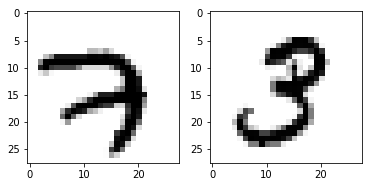

In [252]:
# Verify data in train dataset

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

Validation data shape (5000, 784)


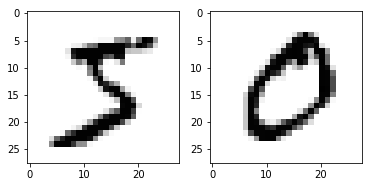

In [253]:
# Verify data in validate dataset

print('Validation data shape', X_valid.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_valid[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_valid[1].reshape(28, 28), cmap=plt.cm.Greys);

Test data shape (10000, 784)


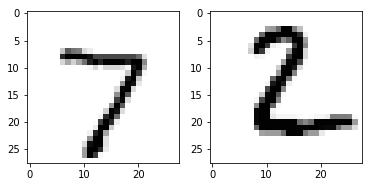

In [254]:
# Verify data in test dataset

print('Test data shape', X_test.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_test[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_test[1].reshape(28, 28), cmap=plt.cm.Greys);

#### Model 1 :  Baseline Model

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.01
- Number of epochs = 20
- batch_size = 50
- activation=tf.nn.relu

In [255]:
# Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M1 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M1 = 100     # 100 hidden neurons in the 2nd layer

In [256]:
# Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [257]:
# Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M1, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M1, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [258]:
# Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [259]:
# Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [260]:
# Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [261]:
# Node to initialize all the variables
init = tf.global_variables_initializer()

In [262]:
# Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [263]:
# EXECUTION PHASE

# Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 50

In [264]:
# Record start time for neral network training
start_time_M1 = time.clock()

In [265]:
# Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8996 Batch accuracy: 0.9 Val accuracy: 0.9024
1 Train Accuracy:  0.9196 Batch accuracy: 0.92 Val accuracy: 0.9254
2 Train Accuracy:  0.9303 Batch accuracy: 0.94 Val accuracy: 0.9372
3 Train Accuracy:  0.9381 Batch accuracy: 0.9 Val accuracy: 0.9416
4 Train Accuracy:  0.9434 Batch accuracy: 0.94 Val accuracy: 0.9472
5 Train Accuracy:  0.9471 Batch accuracy: 0.94 Val accuracy: 0.9512
6 Train Accuracy:  0.9527 Batch accuracy: 1.0 Val accuracy: 0.9548
7 Train Accuracy:  0.9578 Batch accuracy: 0.94 Val accuracy: 0.961
8 Train Accuracy:  0.9607 Batch accuracy: 0.96 Val accuracy: 0.9622
9 Train Accuracy:  0.9632 Batch accuracy: 0.94 Val accuracy: 0.9648
10 Train Accuracy:  0.9665 Batch accuracy: 0.92 Val accuracy: 0.9656
11 Train Accuracy:  0.9681 Batch accuracy: 0.98 Val accuracy: 0.9666
12 Train Accuracy:  0.9691 Batch accuracy: 0.98 Val accuracy: 0.9684
13 Train Accuracy:  0.9718 Batch accuracy: 0.98 Val accuracy: 0.9704
14 Train Accuracy:  0.9737 Batch accuracy: 1.0 V

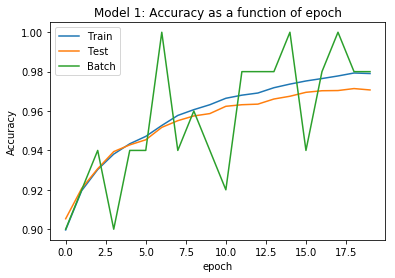

In [266]:
# Training model by using neural network
with tf.Session() as sess:
    init.run()   
    
    acc_train, acc_test, acc_batch = [], [], []
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M1 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M1 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M1 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M1,4), "Batch accuracy:", round(acc_batch_M1,4), "Val accuracy:", round(acc_val_M1,4))
        
        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))

    save_path = saver.save(sess, "./model_1.ckpt")
    
    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 1: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [267]:
# Model 1 prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_1.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M1 = np.argmax(Z, axis=1)
    accuracy_M1 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M1 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_1.ckpt


In [268]:
# Model 01: Print prediction classess and actual classess

print("-------- Model 1 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M1)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M1)

# Record end time for neral network training
stop_time_M1 = time.clock()

# Total processing time
runtime_M1 = stop_time_M1 - start_time_M1

print("\nStart time:           ", start_time_M1)
print("Stop time:            ", stop_time_M1)
print("Processing time:      ", runtime_M1)

#### print("Model  2: Baseline Model + Learning Rate Increase by 0.01 - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.02
- Number of epochs = 20
- batch_size = 50
- activation=tf.nn.relu

In [269]:
# Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         #  10 outputs (0-9)
n_hidden1_M2 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M2 = 150     # 150 hidden neurons in the 2nd layer
n_hidden3_M2 =  50     #  50 hidden neurons in the 3nd layer

In [270]:
# Model 2: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [271]:
# Model 2: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M2, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M2, name="hidden2", activation=tf.nn.relu)
    hidden3 = tf.layers.dense(hidden2, n_hidden3_M2, name="hidden3", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden3, n_outputs, name="outputs")

In [272]:
# Model 2: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [273]:
# Model 2: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.02    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [274]:
# Model 2: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [275]:
# Model 2: Node to initialize all the variables
init = tf.global_variables_initializer()

In [276]:
# Model 2: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [277]:
# EXECUTION PHASE

# Model 2: Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 50

In [278]:
# Model 2: Start Time for neral network training
start_time_M2 = time.clock()

In [279]:
# Model 2: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.9188 Batch accuracy: 0.92 Val accuracy: 0.9238
1 Train Accuracy:  0.9462 Batch accuracy: 0.94 Val accuracy: 0.9508
2 Train Accuracy:  0.9558 Batch accuracy: 0.96 Val accuracy: 0.9594
3 Train Accuracy:  0.9643 Batch accuracy: 0.96 Val accuracy: 0.9644
4 Train Accuracy:  0.9715 Batch accuracy: 0.98 Val accuracy: 0.9702
5 Train Accuracy:  0.9683 Batch accuracy: 0.98 Val accuracy: 0.9684
6 Train Accuracy:  0.9785 Batch accuracy: 1.0 Val accuracy: 0.9752
7 Train Accuracy:  0.9826 Batch accuracy: 1.0 Val accuracy: 0.9776
8 Train Accuracy:  0.9847 Batch accuracy: 1.0 Val accuracy: 0.9776
9 Train Accuracy:  0.986 Batch accuracy: 0.98 Val accuracy: 0.9778
10 Train Accuracy:  0.9891 Batch accuracy: 1.0 Val accuracy: 0.9782
11 Train Accuracy:  0.9893 Batch accuracy: 1.0 Val accuracy: 0.9784
12 Train Accuracy:  0.9857 Batch accuracy: 0.98 Val accuracy: 0.9768
13 Train Accuracy:  0.9898 Batch accuracy: 1.0 Val accuracy: 0.976
14 Train Accuracy:  0.9937 Batch accuracy: 1.0 Val a

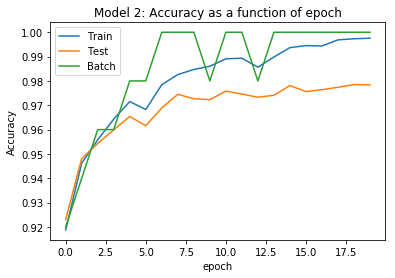

In [280]:
# Model 2: Training model by using neural network
with tf.Session() as sess:
    init.run()
    
    acc_train, acc_test, acc_batch = [], [], []
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M2 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M2   = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M2 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M2,4), "Batch accuracy:", round(acc_batch_M2,4), "Val accuracy:", round(acc_val_M2,4))
        
        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))

    save_path = saver.save(sess, "./model_2.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 2: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [281]:
# Model 2 prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_2.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M2 = np.argmax(Z, axis=1)
    accuracy_M2 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M2 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_2.ckpt


In [282]:
# Model 02: Print prediction classess and actual classess

print("-------- Model 2 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M2)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M2)

# Record end time for neral network training
stop_time_M2 = time.clock()

# Total processing time
runtime_M2 = stop_time_M2 - start_time_M2

print("\nStart time:           ", start_time_M2)
print("Stop time:            ", stop_time_M2)
print("Processing time:      ", runtime_M2)

#### Model  3: Baseline Model + Number of Epochs Increased by 10 - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.02
- Number of epochs = 30
- batch_size = 50
- activation=tf.nn.relu


In [283]:
# Model 3: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M3 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M3 = 100     # 100 hidden neurons in the 2nd layer

In [284]:
# Model 3: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [285]:
# Model 3: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M3, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M3, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [286]:
# Model 3: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [287]:
# Model 3: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [288]:
# Model 3: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [289]:
# Model 3: Node to initialize all the variables
init = tf.global_variables_initializer()

In [290]:
# Model 3: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [291]:
# EXECUTION PHASE

# Model 3: Set number of epochs and batch size for training model.
n_epochs = 30
batch_size = 50

In [292]:
# Model 3: Record start time for neral network training
start_time_M3 = time.clock()

In [293]:
# Model 3: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8996 Batch accuracy: 0.9 Val accuracy: 0.9024
1 Train Accuracy:  0.9196 Batch accuracy: 0.92 Val accuracy: 0.9254
2 Train Accuracy:  0.9303 Batch accuracy: 0.94 Val accuracy: 0.9372
3 Train Accuracy:  0.9381 Batch accuracy: 0.9 Val accuracy: 0.9416
4 Train Accuracy:  0.9434 Batch accuracy: 0.94 Val accuracy: 0.9472
5 Train Accuracy:  0.9471 Batch accuracy: 0.94 Val accuracy: 0.9512
6 Train Accuracy:  0.9527 Batch accuracy: 1.0 Val accuracy: 0.9548
7 Train Accuracy:  0.9578 Batch accuracy: 0.94 Val accuracy: 0.961
8 Train Accuracy:  0.9607 Batch accuracy: 0.96 Val accuracy: 0.9622
9 Train Accuracy:  0.9632 Batch accuracy: 0.94 Val accuracy: 0.9648
10 Train Accuracy:  0.9665 Batch accuracy: 0.92 Val accuracy: 0.9656
11 Train Accuracy:  0.9681 Batch accuracy: 0.98 Val accuracy: 0.9666
12 Train Accuracy:  0.9691 Batch accuracy: 0.98 Val accuracy: 0.9684
13 Train Accuracy:  0.9718 Batch accuracy: 0.98 Val accuracy: 0.9704
14 Train Accuracy:  0.9737 Batch accuracy: 1.0 V

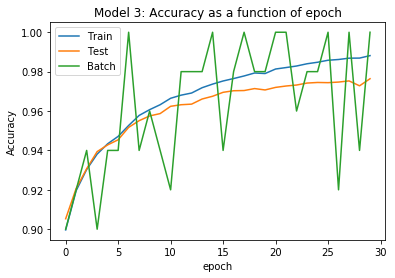

In [294]:
# Model 3: Training model by using neural network
with tf.Session() as sess:
    init.run()
    
    acc_train, acc_test, acc_batch = [], [], []
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M3 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M3 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M3 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M3,4), "Batch accuracy:", round(acc_batch_M3,4), "Val accuracy:", round(acc_val_M3,4))

        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        
    save_path = saver.save(sess, "./model_3.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 3: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [295]:
# Model 3 prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_3.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M3 = np.argmax(Z, axis=1)
    accuracy_M3 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M3 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_3.ckpt


In [296]:
# Model 03: Print prediction classess and actual classess

print("-------- Model 3 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M3)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M3)

# Record end time for neral network training
stop_time_M3 = time.clock()

# Total processing time
runtime_M3 = stop_time_M3 - start_time_M3

print("\nStart time:           ", start_time_M3)
print("Stop time:            ", stop_time_M3)
print("Processing time:      ", runtime_M3)

#### Model  4: Baseline Model + Batch Size Increase by 25 - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.01
- Number of epochs = 20
- batch_size = 75
- activation=tf.nn.relu

In this model, all the hyper parameters were left unchanged as in Model 1 but the number of epochs was increased by 10 (changed to "30" from "20").

In [297]:
# Model 4: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M4 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M4 = 100     # 100 hidden neurons in the 2nd layer

In [298]:
# Model 4: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [299]:
# Model 4: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M4, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M4, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [300]:
# Model 4: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [301]:
# Model 4: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [302]:
# Model 4: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [303]:
# Model 4: Node to initialize all the variables
init = tf.global_variables_initializer()

In [304]:
# Model 4: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [305]:
# EXECUTION PHASE

# Model 4: Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 75

In [306]:
# Model 4: Record start time for neral network training
start_time_M4 = time.clock()

In [307]:
# Model 4: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8849 Batch accuracy: 0.8933 Val accuracy: 0.8898
1 Train Accuracy:  0.9077 Batch accuracy: 0.9467 Val accuracy: 0.9136
2 Train Accuracy:  0.9185 Batch accuracy: 0.92 Val accuracy: 0.925
3 Train Accuracy:  0.9271 Batch accuracy: 0.92 Val accuracy: 0.9342
4 Train Accuracy:  0.9331 Batch accuracy: 0.9333 Val accuracy: 0.9384
5 Train Accuracy:  0.9365 Batch accuracy: 0.92 Val accuracy: 0.941
6 Train Accuracy:  0.942 Batch accuracy: 0.9467 Val accuracy: 0.946
7 Train Accuracy:  0.9462 Batch accuracy: 0.96 Val accuracy: 0.9482
8 Train Accuracy:  0.9492 Batch accuracy: 0.96 Val accuracy: 0.9506
9 Train Accuracy:  0.9521 Batch accuracy: 0.9333 Val accuracy: 0.9546
10 Train Accuracy:  0.9552 Batch accuracy: 0.9467 Val accuracy: 0.9588
11 Train Accuracy:  0.957 Batch accuracy: 0.9467 Val accuracy: 0.9608
12 Train Accuracy:  0.9587 Batch accuracy: 0.9867 Val accuracy: 0.961
13 Train Accuracy:  0.9613 Batch accuracy: 0.9467 Val accuracy: 0.964
14 Train Accuracy:  0.9636 Batch 

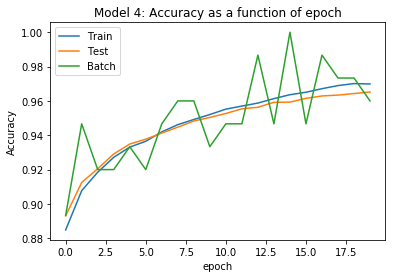

In [308]:
# Model 4: Training model by using neural network
with tf.Session() as sess:
    init.run() 
    
    acc_train, acc_test, acc_batch = [], [], []
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M4 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M4 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M4 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M4,4), "Batch accuracy:", round(acc_batch_M4,4), "Val accuracy:", round(acc_val_M4,4))

        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        
    save_path = saver.save(sess, "./model_4.ckpt")
    
    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 4: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [309]:
# Model 4: prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_4.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M4 = np.argmax(Z, axis=1)
    accuracy_M4 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M4 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_4.ckpt


In [310]:
# Model 04: Print prediction classess and actual classess

print("-------- Model 4 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M4)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M4)

# Record end time for neral network training
stop_time_M4 = time.clock()

# Total processing time
runtime_M4 = stop_time_M4 - start_time_M4

print("\nStart time:           ", start_time_M4)
print("Stop time:            ", stop_time_M4)
print("Processing time:      ", runtime_M4)

#### Model  5: Baseline Model + Batch Size by 25 / Number of Epochs Increase by 10   - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.01
- Number of epochs = 30
- batch_size = 75
- activation=tf.nn.relu

In this model, all the hyper parameters were left unchanged as in Model 1 but the number of epochs was increased by 10 (changed to "30" from "20").

In [311]:
# Model 5: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M5 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M5 = 100     # 100 hidden neurons in the 2nd layer

In [312]:
# Model 5: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [313]:
# Model 5: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M5, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M5, name="hidden2", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [314]:
# Model 5: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [315]:
# Model 5: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [316]:
# Model 5: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [317]:
# Model 5: Node to initialize all the variables
init = tf.global_variables_initializer()

In [318]:
# Model 5: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [319]:
# EXECUTION PHASE

# Model 5: Set number of epochs and batch size for training model.
n_epochs = 30
batch_size = 75

In [320]:
# Model 5: Record start time for neral network training
start_time_M5 = time.clock()

In [321]:
# Model 5: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8849 Batch accuracy: 0.8933 Val accuracy: 0.8898
1 Train Accuracy:  0.9077 Batch accuracy: 0.9467 Val accuracy: 0.9136
2 Train Accuracy:  0.9185 Batch accuracy: 0.92 Val accuracy: 0.925
3 Train Accuracy:  0.9271 Batch accuracy: 0.92 Val accuracy: 0.9342
4 Train Accuracy:  0.9331 Batch accuracy: 0.9333 Val accuracy: 0.9384
5 Train Accuracy:  0.9365 Batch accuracy: 0.92 Val accuracy: 0.941
6 Train Accuracy:  0.942 Batch accuracy: 0.9467 Val accuracy: 0.946
7 Train Accuracy:  0.9462 Batch accuracy: 0.96 Val accuracy: 0.9482
8 Train Accuracy:  0.9492 Batch accuracy: 0.96 Val accuracy: 0.9506
9 Train Accuracy:  0.9521 Batch accuracy: 0.9333 Val accuracy: 0.9546
10 Train Accuracy:  0.9552 Batch accuracy: 0.9467 Val accuracy: 0.9588
11 Train Accuracy:  0.957 Batch accuracy: 0.9467 Val accuracy: 0.9608
12 Train Accuracy:  0.9587 Batch accuracy: 0.9867 Val accuracy: 0.961
13 Train Accuracy:  0.9613 Batch accuracy: 0.9467 Val accuracy: 0.964
14 Train Accuracy:  0.9636 Batch 

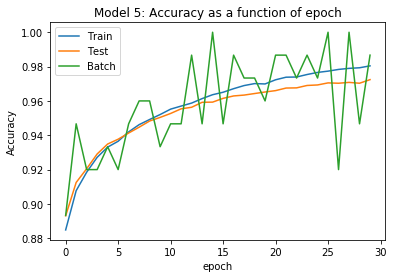

In [322]:
# Model 5: Training model by using neural network
with tf.Session() as sess:
    init.run()
        
    acc_train, acc_test, acc_batch = [], [], []
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M5 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M5 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M5 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M5,4), "Batch accuracy:", round(acc_batch_M5,4), "Val accuracy:", round(acc_val_M5,4))

        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        
    save_path = saver.save(sess, "./model_5.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 5: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [323]:
# Model 5: prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_5.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M5 = np.argmax(Z, axis=1)
    accuracy_M5 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M5 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_5.ckpt


In [324]:
# Model 05: Print prediction classess and actual classess

print("-------- Model 5 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M5)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M5)

# Record end time for neral network training
stop_time_M5 = time.clock()

# Total processing time
runtime_M5 = stop_time_M5 - start_time_M5

print("\nStart time:           ", start_time_M5)
print("Stop time:            ", stop_time_M5)
print("Processing time:      ", runtime_M5)

#### Model  6: Baseline Model + Activation = tanh - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.01
- Number of epochs = 20
- batch_size = 50
- activation=tf.nn.tanu

In this model, all the hyper parameters were left unchanged as in Model 1 but the activation was changes from "relu" to "tanu".

In [325]:
# Model 6: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M6 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M6 = 100     # 100 hidden neurons in the 2nd layer

In [326]:
# Model 6: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [327]:
# Model 6: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M6, name="hidden1", activation=tf.nn.tanh)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M6, name="hidden2", activation=tf.nn.tanh)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [328]:
# Model 6: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [329]:
# Model 6: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [330]:
# Model 6: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [331]:
# Model 6: Node to initialize all the variables
init = tf.global_variables_initializer()

In [332]:
# Model 6: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [333]:
# EXECUTION PHASE

# Model 6: Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 50

In [334]:
# Model 6: Record start time for neral network training
start_time_M6 = time.clock()

In [335]:
# Model 6: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8933 Batch accuracy: 0.86 Val accuracy: 0.9018
1 Train Accuracy:  0.9089 Batch accuracy: 0.92 Val accuracy: 0.9178
2 Train Accuracy:  0.9184 Batch accuracy: 0.92 Val accuracy: 0.925
3 Train Accuracy:  0.9247 Batch accuracy: 0.9 Val accuracy: 0.9298
4 Train Accuracy:  0.9299 Batch accuracy: 0.94 Val accuracy: 0.934
5 Train Accuracy:  0.934 Batch accuracy: 0.94 Val accuracy: 0.9364
6 Train Accuracy:  0.9384 Batch accuracy: 1.0 Val accuracy: 0.9432
7 Train Accuracy:  0.9425 Batch accuracy: 0.94 Val accuracy: 0.9456
8 Train Accuracy:  0.9458 Batch accuracy: 0.94 Val accuracy: 0.9466
9 Train Accuracy:  0.9481 Batch accuracy: 0.88 Val accuracy: 0.9528
10 Train Accuracy:  0.9508 Batch accuracy: 0.9 Val accuracy: 0.9544
11 Train Accuracy:  0.9529 Batch accuracy: 0.94 Val accuracy: 0.9546
12 Train Accuracy:  0.9543 Batch accuracy: 0.98 Val accuracy: 0.9576
13 Train Accuracy:  0.9567 Batch accuracy: 0.96 Val accuracy: 0.9612
14 Train Accuracy:  0.9586 Batch accuracy: 1.0 Val

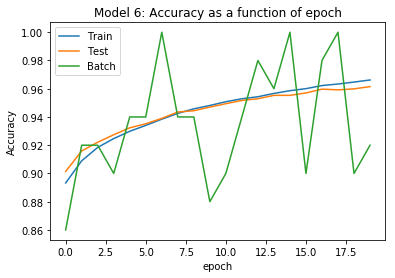

In [336]:
# Model 6: Training model by using neural network
with tf.Session() as sess:
    init.run() 
    
    acc_train, acc_test, acc_batch = [], [], []
  
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M6 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M6 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M6 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M6,4), "Batch accuracy:", round(acc_batch_M6,4), "Val accuracy:", round(acc_val_M6,4))

        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))

    save_path = saver.save(sess, "./model_6.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 6: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [337]:
# Model 6: prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_6.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M6 = np.argmax(Z, axis=1)
    accuracy_M6 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M6 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_6.ckpt


In [338]:
# Model 06: Print prediction classess and actual classess

print("-------- Model 6 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M6)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M6)

# Record end time for neral network training
stop_time_M6 = time.clock()

# Total processing time
runtime_M6 = stop_time_M6 - start_time_M6

print("\nStart time:           ", start_time_M6)
print("Stop time:            ", stop_time_M6)
print("Processing time:      ", runtime_M6)

#### Model  7: Baseline Model + Activation = tanh + Batch Size Increase by 25 - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.01
- Number of epochs = 20
- batch_size = 75
- activation=tf.nn.tanh


In [339]:
# Model 7: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M7 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M7 = 100     # 100 hidden neurons in the 2nd layer

In [340]:
# Model 7: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [341]:
# Model 7: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M7, name="hidden1", activation=tf.nn.tanh)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M7, name="hidden2", activation=tf.nn.tanh)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [342]:
# Model 7: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [343]:
# Model 7: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [344]:
# Model 7: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [345]:
# Model 7: Node to initialize all the variables
init = tf.global_variables_initializer()

In [346]:
# Model 7: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [347]:
# EXECUTION PHASE

# Model 7: Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 75

In [348]:
# Model 7: Record start time for neral network training
start_time_M7 = time.clock()

In [349]:
# Model 7: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8826 Batch accuracy: 0.8933 Val accuracy: 0.8916
1 Train Accuracy:  0.9003 Batch accuracy: 0.9333 Val accuracy: 0.9078
2 Train Accuracy:  0.9087 Batch accuracy: 0.9067 Val accuracy: 0.9174
3 Train Accuracy:  0.9155 Batch accuracy: 0.9067 Val accuracy: 0.9248
4 Train Accuracy:  0.9201 Batch accuracy: 0.9333 Val accuracy: 0.9266
5 Train Accuracy:  0.9243 Batch accuracy: 0.9067 Val accuracy: 0.93
6 Train Accuracy:  0.9285 Batch accuracy: 0.9333 Val accuracy: 0.9338
7 Train Accuracy:  0.9326 Batch accuracy: 0.96 Val accuracy: 0.9366
8 Train Accuracy:  0.9353 Batch accuracy: 0.9467 Val accuracy: 0.9388
9 Train Accuracy:  0.9381 Batch accuracy: 0.9067 Val accuracy: 0.9412
10 Train Accuracy:  0.9412 Batch accuracy: 0.9333 Val accuracy: 0.944
11 Train Accuracy:  0.9429 Batch accuracy: 0.92 Val accuracy: 0.944
12 Train Accuracy:  0.9447 Batch accuracy: 0.9733 Val accuracy: 0.947
13 Train Accuracy:  0.9466 Batch accuracy: 0.9333 Val accuracy: 0.9498
14 Train Accuracy:  0.948

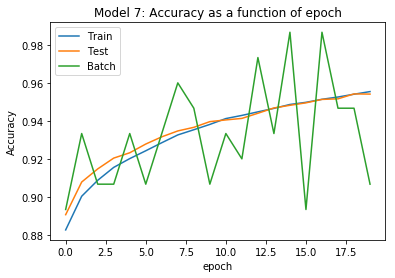

In [350]:
# Model 7: Training model by using neural network
with tf.Session() as sess:
    init.run()
    
    acc_train, acc_test, acc_batch = [], [], []
   
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M7 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M7 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M7 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M7,4), "Batch accuracy:", round(acc_batch_M7,4), "Val accuracy:", round(acc_val_M7,4))
    
        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))
        
    save_path = saver.save(sess, "./model_7.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 7: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [351]:
# Model 7: prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_7.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M7 = np.argmax(Z, axis=1)
    accuracy_M7 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M7 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_7.ckpt


In [352]:
# Model 07: Print prediction classess and actual classess

print("-------- Model 7 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M7)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M7)

# Record end time for neral network training
stop_time_M7 = time.clock()

# Total processing time
runtime_M7 = stop_time_M7 - start_time_M7

print("\nStart time:           ", start_time_M7)
print("Stop time:            ", stop_time_M7)
print("Processing time:      ", runtime_M7)

#### Model  8: Baseline Model + Activation = tanh + Number of Epochs Increased by 10 - 2 Layers (300:100 neurons)

- Number of Layers = 2
- Number of hidden neurons: Layer 1 = 300
- Number of hidden neurons: Layer 2 = 100
- learning_rate = 0.01
- Number of epochs = 30
- batch_size = 50
- activation=tf.nn.tanh


In [353]:
# Model 8: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         # 10 outputs (0-9)
n_hidden1_M8 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M8 = 100     # 100 hidden neurons in the 2nd layer

In [354]:
# Model 8: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [355]:
# Model 8: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M8, name="hidden1", activation=tf.nn.tanh)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M8, name="hidden2", activation=tf.nn.tanh)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [356]:
# Model 8: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [357]:
# Model 8: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [358]:
# Model 8: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [359]:
# Model 8: Node to initialize all the variables
init = tf.global_variables_initializer()

In [360]:
# Model 8: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [361]:
# EXECUTION PHASE

# Model 8: Set number of epochs and batch size for training model.
n_epochs = 30
batch_size = 50

In [362]:
# Model 8: Record start time for neral network training
start_time_M8 = time.clock()

In [363]:
# Model 8: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8933 Batch accuracy: 0.86 Val accuracy: 0.9018
1 Train Accuracy:  0.9089 Batch accuracy: 0.92 Val accuracy: 0.9178
2 Train Accuracy:  0.9184 Batch accuracy: 0.92 Val accuracy: 0.925
3 Train Accuracy:  0.9247 Batch accuracy: 0.9 Val accuracy: 0.9298
4 Train Accuracy:  0.9299 Batch accuracy: 0.94 Val accuracy: 0.934
5 Train Accuracy:  0.934 Batch accuracy: 0.94 Val accuracy: 0.9364
6 Train Accuracy:  0.9384 Batch accuracy: 1.0 Val accuracy: 0.9432
7 Train Accuracy:  0.9425 Batch accuracy: 0.94 Val accuracy: 0.9456
8 Train Accuracy:  0.9458 Batch accuracy: 0.94 Val accuracy: 0.9466
9 Train Accuracy:  0.9481 Batch accuracy: 0.88 Val accuracy: 0.9528
10 Train Accuracy:  0.9508 Batch accuracy: 0.9 Val accuracy: 0.9544
11 Train Accuracy:  0.9529 Batch accuracy: 0.94 Val accuracy: 0.9546
12 Train Accuracy:  0.9543 Batch accuracy: 0.98 Val accuracy: 0.9576
13 Train Accuracy:  0.9567 Batch accuracy: 0.96 Val accuracy: 0.9612
14 Train Accuracy:  0.9586 Batch accuracy: 1.0 Val

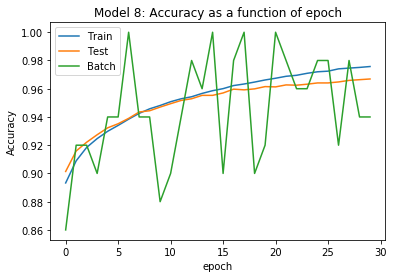

In [364]:
# Model 8: Training model by using neural network
with tf.Session() as sess:
    init.run()
    
    acc_train, acc_test, acc_batch = [], [], []
   
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M8 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M8 = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M8 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M8,4), "Batch accuracy:", round(acc_batch_M8,4), "Val accuracy:", round(acc_val_M8,4))
    
        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))

    save_path = saver.save(sess, "./model_8.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 8: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [365]:
# Model 8: prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_8.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M8 = np.argmax(Z, axis=1)
    accuracy_M8 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M8 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_8.ckpt


In [366]:
# Model 08: Print prediction classess and actual classess

print("-------- Model 8 --------")
print("300 neurons (1st layer),  100 neurons (2nd layer)")
print("\nPredicted classes:   ", y_pred_M8)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M8)

# Record end time for neral network training
stop_time_M8 = time.clock()

# Total processing time
runtime_M8 = stop_time_M8 - start_time_M8

print("\nStart time:           ", start_time_M8)
print("Stop time:            ", stop_time_M8)
print("Processing time:      ", runtime_M8)

##### Model  9: Baseline Model + New Layer + All Hyper-Parameters Unchanged - 3 Layers (300:150:50 neurons)
- Increased the layers to 3
- Layer 1 = 300 hidden neurons
- Layer 2 = 150 hidden neurons
- Layer 3 =  50 hidden neurons
- learning_rate = 0.01
- Number of epochs = 20
- batch_size = 50
- activation=tf.nn.relu 

In [367]:
# Model 9: Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 2 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         #  10 outputs (0-9)
n_hidden1_M9 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M9 = 150     # 150 hidden neurons in the 2nd layer
n_hidden3_M9 =  50     #  50 hidden neurons in the 3nd layer

In [368]:
# Model 9: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [369]:
# Model 9: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M9, name="hidden1", activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M9, name="hidden2", activation=tf.nn.relu)
    hidden3 = tf.layers.dense(hidden2, n_hidden3_M9, name="hidden3", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden3, n_outputs, name="outputs")

In [370]:
# Model 9: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [371]:
# Model 9: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [372]:
# Model 9: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [373]:
# Model 2: Node to initialize all the variables
init = tf.global_variables_initializer()

In [374]:
# Model 9: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [375]:
# EXECUTION PHASE

# Model 9: Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 50

In [376]:
# Model 2: Start Time for neral network training
start_time_M9 = time.clock()

In [377]:
# Model 9: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.9035 Batch accuracy: 0.9 Val accuracy: 0.907
1 Train Accuracy:  0.9263 Batch accuracy: 0.92 Val accuracy: 0.9328
2 Train Accuracy:  0.9371 Batch accuracy: 0.96 Val accuracy: 0.9426
3 Train Accuracy:  0.9453 Batch accuracy: 0.92 Val accuracy: 0.9502
4 Train Accuracy:  0.9531 Batch accuracy: 0.98 Val accuracy: 0.9566
5 Train Accuracy:  0.9545 Batch accuracy: 0.94 Val accuracy: 0.9594
6 Train Accuracy:  0.962 Batch accuracy: 1.0 Val accuracy: 0.9638
7 Train Accuracy:  0.9671 Batch accuracy: 0.96 Val accuracy: 0.9676
8 Train Accuracy:  0.9698 Batch accuracy: 0.98 Val accuracy: 0.9696
9 Train Accuracy:  0.9718 Batch accuracy: 0.96 Val accuracy: 0.9706
10 Train Accuracy:  0.9755 Batch accuracy: 0.94 Val accuracy: 0.9718
11 Train Accuracy:  0.9769 Batch accuracy: 1.0 Val accuracy: 0.973
12 Train Accuracy:  0.9764 Batch accuracy: 0.98 Val accuracy: 0.9728
13 Train Accuracy:  0.9801 Batch accuracy: 0.98 Val accuracy: 0.9736
14 Train Accuracy:  0.9821 Batch accuracy: 1.0 Val

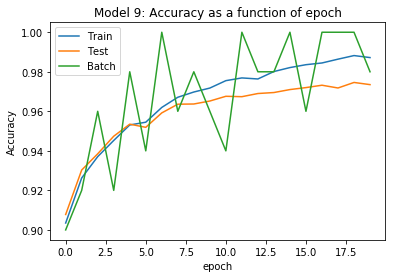

In [378]:
# Model 9: Training model by using neural network
with tf.Session() as sess:
    init.run()
    
    acc_train, acc_test, acc_batch = [], [], []
   
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M9 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M9   = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M9 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M9,4), "Batch accuracy:", round(acc_batch_M9,4), "Val accuracy:", round(acc_val_M9,4))
    
        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))

    save_path = saver.save(sess, "./model_9.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 9: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [379]:
# Model 9 prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_9.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M9 = np.argmax(Z, axis=1)
    accuracy_M9 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M9 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_9.ckpt


In [380]:
# Model 09: Print prediction classess and actual classess

print("-------- Model 9 --------")
print("300 neurons (1st layer), 150 neurons (2nd layer), 50 neurons (3rd layer)")
print("\nPredicted classes:   ", y_pred_M9)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M9)

# Record end time for neral network training
stop_time_M9 = time.clock()

# Total processing time
runtime_M9 = stop_time_M9 - start_time_M9

print("\nStart time:           ", start_time_M9)
print("Stop time:            ", stop_time_M9)
print("Processing time:      ", runtime_M9)

##### Model 10: Baseline Model + New Layer + Activation = tanh - 3 Layers (300:150:50 neurons)
- Increased the layers to 3
- Layer 1 = 300 hidden neurons
- Layer 2 = 150 hidden neurons
- Layer 3 =  50 hidden neurons
- learning_rate = 0.01
- Number of epochs = 20
- batch_size = 50
- activation=tf.nn.tanh 

In [381]:
# Specify the number of inputs and outputs, and set the number of hidden neurons in each layer
# Neural Network - 10 layers

n_inputs = 28*28       # MNIST features = 28 pixcels n 28 pixcels for input
n_outputs = 10         #  10 outputs (0-9)
n_hidden1_M10 = 300     # 300 hidden neurons in the 1st layer
n_hidden2_M10 = 150     # 150 hidden neurons in the 2nd layer
n_hidden3_M10 =  50     #  50 hidden neurons in the 3nd layer

In [382]:
# Model 10: Setup placeholder nodes to represent the training data and targets

reset_graph() #reset previous graph not to disturve the following process. 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [383]:
# Model 10: Create Neural Network　with tf.layers.dense()
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1_M10, name="hidden1", activation=tf.nn.tanh)
    hidden2 = tf.layers.dense(hidden1, n_hidden2_M10, name="hidden2", activation=tf.nn.tanh)
    hidden3 = tf.layers.dense(hidden2, n_hidden3_M10, name="hidden3", activation=tf.nn.tanh)
    logits = tf.layers.dense(hidden3, n_outputs, name="outputs")

In [384]:
# Model 10: Cost function for training Neural Network

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [385]:
# Model 10: Gradient Descent Optimizer to minimize the cost function by learning_rate = 0.01 
# scope allows to assign multiple operations to a training run
learning_rate = 0.01    # possible change learn rate ( learning rate, Epoch and batch size)

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [386]:
# Model 10: Measure classification performance by in_top_k().
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [387]:
# Model 10: Node to initialize all the variables
init = tf.global_variables_initializer()

In [388]:
# Model 10: Create saver to save trained parameters.
saver = tf.train.Saver(save_relative_paths=True) 

In [389]:
# EXECUTION PHASE

# Model 10: Set number of epochs and batch size for training model.
n_epochs = 20
batch_size = 50

In [390]:
# Model 10: Start Time for neral network training
start_time_M10 = time.clock()

In [391]:
# Model 10: Create function to shuffle training data
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

0 Train Accuracy:  0.8963 Batch accuracy: 0.9 Val accuracy: 0.9034
1 Train Accuracy:  0.9132 Batch accuracy: 0.94 Val accuracy: 0.92
2 Train Accuracy:  0.9225 Batch accuracy: 0.92 Val accuracy: 0.928
3 Train Accuracy:  0.9301 Batch accuracy: 0.86 Val accuracy: 0.9334
4 Train Accuracy:  0.9352 Batch accuracy: 0.94 Val accuracy: 0.9372
5 Train Accuracy:  0.9399 Batch accuracy: 0.94 Val accuracy: 0.9396
6 Train Accuracy:  0.9453 Batch accuracy: 1.0 Val accuracy: 0.9454
7 Train Accuracy:  0.9496 Batch accuracy: 0.94 Val accuracy: 0.9502
8 Train Accuracy:  0.9529 Batch accuracy: 0.98 Val accuracy: 0.9528
9 Train Accuracy:  0.9557 Batch accuracy: 0.92 Val accuracy: 0.956
10 Train Accuracy:  0.9589 Batch accuracy: 0.92 Val accuracy: 0.9592
11 Train Accuracy:  0.9615 Batch accuracy: 0.98 Val accuracy: 0.961
12 Train Accuracy:  0.9629 Batch accuracy: 0.98 Val accuracy: 0.9612
13 Train Accuracy:  0.9654 Batch accuracy: 0.98 Val accuracy: 0.9642
14 Train Accuracy:  0.9679 Batch accuracy: 1.0 Val 

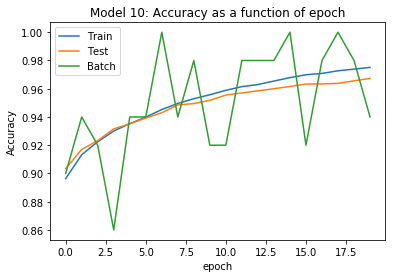

In [392]:
# Model 10: Training model by using neural network
with tf.Session() as sess:
    init.run()    
    
    acc_train, acc_test, acc_batch = [], [], []
   
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch_M10 = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val_M10   = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_train_M10 = accuracy.eval(feed_dict={X: X_train, y: y_train})
        print(epoch, "Train Accuracy: ", round(acc_train_M10,4), "Batch accuracy:", round(acc_batch_M10,4), "Val accuracy:", round(acc_val_M10,4))

        acc_train.append(accuracy.eval(feed_dict={X: X_train, y: y_train}))
        acc_test.append(accuracy.eval(feed_dict={X: X_test, y: y_test}))
        acc_batch.append(accuracy.eval(feed_dict={X: X_batch, y: y_batch}))

    save_path = saver.save(sess, "./model_10.ckpt")

    plt.plot(range(n_epochs), acc_train, label="Train")
    plt.plot(range(n_epochs), acc_test, label="Test")
    plt.plot(range(n_epochs), acc_batch, label="Batch")
    plt.title('Model 10: Accuracy as a function of epoch')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [393]:
# Model 10 prediction using test data

with tf.Session() as sess:
    saver.restore(sess, "./model_10.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred_M10 = np.argmax(Z, axis=1)
    accuracy_M10 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    ac_train_M10 = accuracy.eval(feed_dict={X: X_train, y: y_train})

INFO:tensorflow:Restoring parameters from ./model_10.ckpt


In [394]:
# Model 10: Print prediction classess and actual classess

print("-------- Model 10 --------")
print("300 neurons (1st layer), 150 neurons (2nd layer), 50 neurons (3rd layer)")
print("\nPredicted classes:   ", y_pred_M10)
print("Actual classes:      ", y_test[:20])
print("Test Set Accracy:    ", accuracy_M10)

# Record end time for neral network training
stop_time_M10 = time.clock()

# Total processing time
runtime_M10 = stop_time_M10 - start_time_M10 

print("\nStart time:           ", start_time_M10)
print("Stop time:            ", stop_time_M10)
print("Processing time:      ", runtime_M10)

#### Model Predictions using test dataset.
- Recall all saved model parameters

In [414]:
# Print prediction classess and actual classess.

print("-------- COMPREHENSIVE MODEL STATISTICS --------")

print("\nModel 1: Predicted classes:     ", y_pred_M1)
print("Model 2: Predicted classes:     ", y_pred_M2)
print("Model 3: Predicted classes:     ", y_pred_M3)
print("Model 4: Predicted classes:     ", y_pred_M4)
print("Model 5: Predicted classes:     ", y_pred_M5)
print("Model 6: Predicted classes:     ", y_pred_M6)
print("Model 7: Predicted classes:     ", y_pred_M7)
print("Model 8: Predicted classes:     ", y_pred_M8)
print("Model 9: Predicted classes:     ", y_pred_M9)
print("Model 10: Predicted classes:    ", y_pred_M10)

print("\nModel 1: Actual classes:       ", y_test[:20])

print("\nModel  1: Test Set Accracy:     ", accuracy_M1)
print("Model  2: Test Set Accracy:     ", accuracy_M2)
print("Model  3: Test Set Accracy:     ", accuracy_M3)
print("Model  4: Test Set Accracy:     ", accuracy_M4)
print("Model  5: Test Set Accracy:     ", accuracy_M5)
print("Model  6: Test Set Accracy:     ", accuracy_M6)
print("Model  7: Test Set Accracy:     ", accuracy_M7)
print("Model  8: Test Set Accracy:     ", accuracy_M8)
print("Model  9: Test Set Accracy:     ", accuracy_M9)
print("Model 10: Test Set Accracy:     ", accuracy_M10)

# Total processing time
runtime_M1 = stop_time_M1 - start_time_M1 
runtime_M2 = stop_time_M2 - start_time_M2
runtime_M3 = stop_time_M3 - start_time_M3
runtime_M4 = stop_time_M4 - start_time_M4
runtime_M5 = stop_time_M5 - start_time_M5
runtime_M6 = stop_time_M6 - start_time_M6
runtime_M7 = stop_time_M7 - start_time_M7
runtime_M8 = stop_time_M8 - start_time_M8
runtime_M9 = stop_time_M9 - start_time_M9
runtime_M10 = stop_time_M10 - start_time_M10

print("\nModel        Start Time       Stop Time      Processing Time")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("M1            ", "%.3f" % start_time_M1,"     ", "%.3f" % stop_time_M1,"     ", "%.3f" % runtime_M1)
print("M2            ", "%.3f" % start_time_M2,"     ", "%.3f" % stop_time_M2,"     ", "%.3f" % runtime_M2)
print("M3            ", "%.3f" % start_time_M3,"     ", "%.3f" % stop_time_M3,"     ", "%.3f" % runtime_M3)
print("M4            ", "%.3f" % start_time_M4,"     ", "%.3f" % stop_time_M4,"     ", "%.3f" % runtime_M4)
print("M5            ", "%.3f" % start_time_M5,"     ", "%.3f" % stop_time_M5,"     ", "%.3f" % runtime_M5)
print("M6            ", "%.3f" % start_time_M6,"     ", "%.3f" % stop_time_M6,"     ", "%.3f" % runtime_M6)
print("M7            ", "%.3f" % start_time_M7,"     ", "%.3f" % stop_time_M7,"     ", "%.3f" % runtime_M7)
print("M8            ", "%.3f" % start_time_M8,"     ", "%.3f" % stop_time_M8,"     ", "%.3f" % runtime_M8)
print("M9            ", "%.3f" % start_time_M9,"     ", "%.3f" % stop_time_M9,"     ", "%.3f" % runtime_M9)
print("M10           ", "%.3f" % start_time_M10,"     ", "%.3f" % stop_time_M10,"     ", "%.3f" % runtime_M10)


## Create Table for Tensor Flow Neural Network Benchmark Experiment Results
col_labels = ['Model', 'No of Layers', 'Nodes per Layer', 'Processing Time','Train Set Accuracy', 'Test Set Accuracy']
# table_vals = []
table = tabulate(table_vals, headers=col_labels, tablefmt="simple",numalign="left")
mtr = "{}          {}          {}        {}            {}                 {}"

print("\nNeural Network Model Descriptions Legend")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
print("M1  = Model  1: Baseline Model                                                        - 2 Layers (300:100 neurons)" )
print("M2  = Model  2: Baseline Model + Learning Rate Increase by 0.01                       - 2 Layers (300:100 neurons)" )
print("M3  = Model  3: Baseline Model + Number of Epochs Increased by 10                     - 2 Layers (300:100 neurons)" )
print("M4  = Model  4: Baseline Model + Batch Size Increase by 25                            - 2 Layers (300:100 neurons)" )
print("M5  = Model  5: Baseline Model + Batch Size by 25 / Number of Epochs Increase by 10   - 2 Layers (300:100 neurons)" )
print("M6  = Model  6: Baseline Model + Activation = tanh                                    - 2 Layers (300:100 neurons)" )
print("M7  = Model  7: Baseline Model + Activation = tanh + Batch Size Increase by 25        - 2 Layers (300:100 neurons)" )
print("M8  = Model  8: Baseline Model + Activation = tanh + Number of Epochs Increased by 10 - 2 Layers (300:100 neurons)" )
print("M9  = Model  9: Baseline Model + New Layer + All Hyper-Parameters Unchanged           - 3 Layers (300:150:50 neurons)" )
print("M10 = Model 10: Baseline Model + New Layer + Activation = tanh                        - 3 Layers (300:150:50 neurons)\n" )

print('-------- Table for Neural Network Benchmark Experiment Results: 10 Different Models\n' )
print(table)

print(mtr.format('M1 ','2 ','300:100    ',"%.3f" % runtime_M1 , "%.3f" % ac_train_M1 , "%.3f" % accuracy_M1))
print(mtr.format('M2 ','2 ','300:100    ',"%.3f" % runtime_M2 , "%.3f" % ac_train_M2 , "%.3f" % accuracy_M2))
print(mtr.format('M3 ','2 ','300:100    ',"%.3f" % runtime_M3 , "%.3f" % ac_train_M3 , "%.3f" % accuracy_M3))
print(mtr.format('M4 ','2 ','300:100    ',"%.3f" % runtime_M4 , "%.3f" % ac_train_M4 , "%.3f" % accuracy_M4))
print(mtr.format('M5 ','2 ','300:100    ',"%.3f" % runtime_M5 , "%.3f" % ac_train_M5 , "%.3f" % accuracy_M5))
print(mtr.format('M6 ','2 ','300:100    ',"%.3f" % runtime_M6 , "%.3f" % ac_train_M6 , "%.3f" % accuracy_M6))
print(mtr.format('M7 ','2 ','300:100    ',"%.3f" % runtime_M7 , "%.3f" % ac_train_M7 , "%.3f" % accuracy_M7))
print(mtr.format('M8 ','2 ','300:100    ',"%.3f" % runtime_M8 , "%.3f" % ac_train_M8 , "%.3f" % accuracy_M8))
print(mtr.format('M9 ','3 ','300:150:50 ',"%.3f" % runtime_M9 , "%.3f" % ac_train_M9 , "%.3f" % accuracy_M9))
print(mtr.format('M10','3 ','300:150:50 ',"%.3f" % runtime_M10, "%.3f" % ac_train_M10, "%.3f" % accuracy_M10))

-------- COMPREHENSIVE MODEL STATISTICS --------

Model 1: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 2: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 3: Predicted classes:      [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Model 4: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 5: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 6: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 7: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 8: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 9: Predicted classes:      [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Model 10: Predicted classes:     [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]

Model 1: Actual classes:        [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]

Model  1: Test Set Accracy:      0.9707
Model  2: Test Set Accracy:      0.9784
Model  3: Test Set Accracy:      0.9764
Mode

### REPORT / FINDINGS:

#### OVERVIEW
The objective of this project was to fit a number of neural networks, comparing processing time and performance across experimental treatments (hyper-parameter tuning).



#### RESEARCH DESIGN, MANAGEMENT & STATISTICAL / TRADITIONAL / MACHINE LEARNING METHODS

###### EXPLORATORY DATA ANALYSIS
Exploratory Data Analysis performed on the MNIST dataset to verify the shape of the MNIST dataset. Also after splitting the data set into Train / Test the chapes were also verified prior to starting any modeling activity. 


###### MODELLING
The following models were used in this project previously in the regression model evaluation.
For the modeling steps, 10 different models were run with the hyper-parameters tunes as well. The hyper-parameters tunes were number of epochs, activation, batch sixe, layers and number of neurons, and learning rate.
Below are the models that were run for cost evaluation and accuracy.

- Model-1:  Baseline Model (2 layers [300:100]    neurons; + All hyper-parameters left unchanged)
- Model-2:  Baseline Model (2 layers [300:100]    neurons; + Learning Rate Increase by 0.01; All other hyper-parameters left unchanged)
- Model-3:  Baseline Model (2 layers [300:100]    neurons; + n_epochs Increased by 25 + All other hyper-parameters left unchanged)
- Model-4:  Baseline Model (2 layers [300:100]    neurons; + Batch Size Increase by 25 + All other hyper-parameters left unchanged)
- Model-5:  Baseline Model (2 layers [300:100]    neurons; + Batch Size by 25 / Number of Epochs Increase by 10 + All other hyper-parameters left unchanged)
- Model-6:  Baseline Model (2 layers [300:100]    neurons; + Activation = tanh + All other hyper-parameters left unchanged)
- Model-7:  Baseline Model (2 layers [300:100]    neurons; + Activation = tanh + Batch Size Increase by 25 + All other hyper-parameters left unchanged)
- Model-8:  Baseline Model (2 layers [300:100]    neurons; + Activation = tanh + Number of Epochs Increased by 10 + All other hyper-parameters left unchanged)
- Model-9:  Baseline Model (3 layers [300:150:50] neurons; + New Layer + All Hyper-Parameters Unchanged)
- Model-10: Baseline Model (3 layers [300:150:50] neurons; + New Layer + Activation = tanh + All other hyper-parameters left unchanged)

For each of the model runs, accuracy plots as a function of epoch were generated with plot lines for train set accuracy, test set accuracy and batch accuracy.


###### MODEL PERFORMANCE REPORT
Upon evaluating the model accuracy scores and processing time for each of the modeling steps with its hyper parameters fine-tuned, the following were observed

Model Accuracy:
- Model-2 Baseline Model (2 Layers [300:100 neurons]; + hyper-parameter: learning_rate increased by 0.01) had the highest accuracy score on both the Train and Test sets (99.80% Train set; 97.80 Test set)
- Model-7 Baseline Model (2 layers [300:100 neurons]; + hyper-parameter: Activation = tanh; Batch Size Increase by 25) had the worst accuracy score on both the Train and Test sets (95.50% Train set; 95.4% Test Set)

Model Processing Times
- Model-7 Baseline Model (2 layers [300:100 neurons]; + hyper-parameter: Activation = tanh; Batch Size Increase by 25) had the shortest processing time of 165.781 seconds
- Model-3 Baseline Model (2 Layers [300:100 neurons]; + hyper-parameter: n_Epochs Increased by 10) had the highest processing time of 268.066 seconds.

Looking at this, one might generalize in concluding that processing time is correlated to accuracy. Model 2 which has the longest processing time has an accuracy of 99.85 on 
train set (1% difference compared to Model-2 with the best accuracy score) and 97.6% on the Test set (0.2% difference compared to model-2 with the bast accuracy score)

Its safe to see as the model becomes more complex, the processing time increase and also result there is improvement in the accuracy. While we think of model complexity and how it could improve our model accuracy, we must always be aware of the fact that there are different factors we have to pay close attention to like overfitting. We need to access the cost versus performance tradeoff as we consider fine-tuning the hyper-parameters. With some use cases, accuracy is not the priority but cost. In other cases like in the medical field, accuracy 
is very important.


###### MODEL RECOMMENDATION
Based on the models that performed the best in processing time keeping and being mindful of the accuracy score, the hyper-parameters I would recommend we explore and experiment and tune better are
- number of epochs
- Batch size
- Learning Rate

In terms of the neural network topology, I would recommend maintaining 2 layers with layer one having 300 neurons and layer 2 having 100 neurons.

While we might not see the best accuracy score, the difference compared to the model with the best scores is not great and the overall processing times improved as seen in the output for Model 4 and model 5.